584 146


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:prophet:Making 1 forecasts with cutoffs between 2022-02-08 00:00:00 and 2022-02-08 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2022-02-08 00:00:00 and 2022-02-08 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2022-02-08 00:00:00 and 2022-02-08 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2022-02-08 00:00:00 and 2022-02-08 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2022-02-08 00:00:00 and 2022-02-08 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2022-02-08 00:00:00 and 2022-02-08 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2022-02-08 00:00:00 and 2022-02-08 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


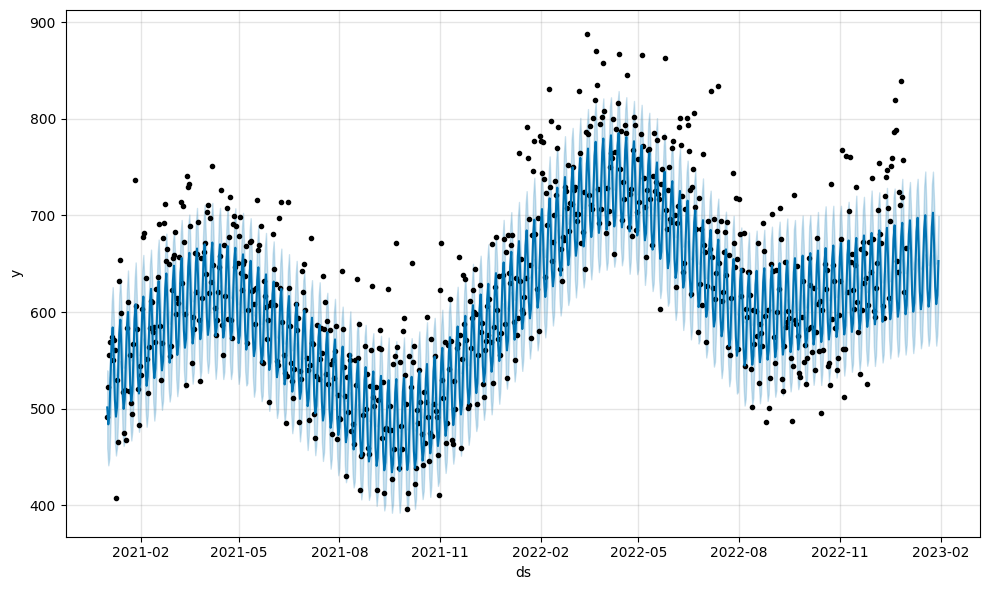

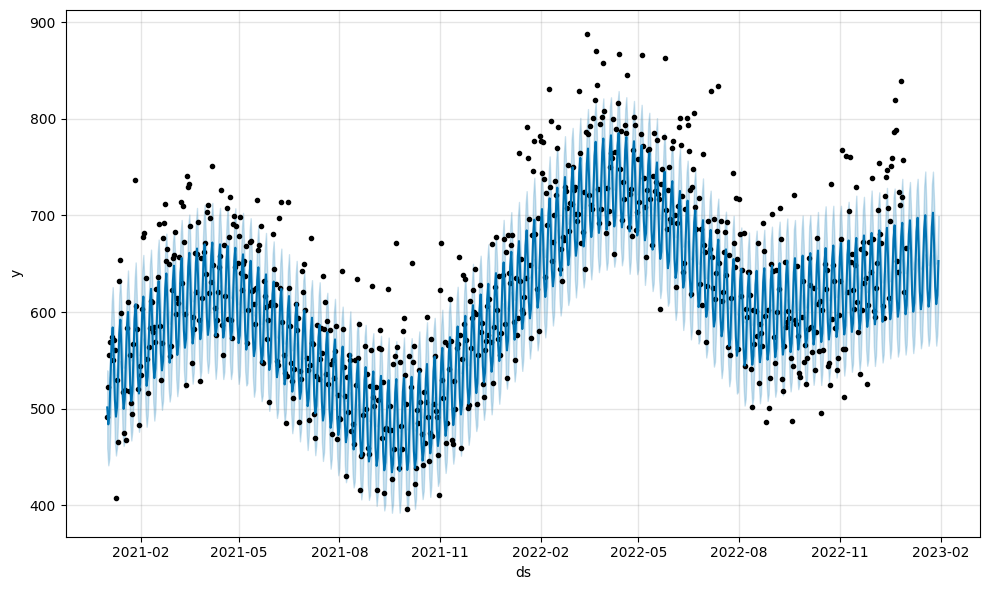

In [1]:
import pandas as pd
import numpy as np

#create date range (2 years)
dates = pd.date_range("2021-01-01", "2022-12-31", freq="D")

np.random.seed(42)

#trend
trend = np.linspace(0, 200, len(dates))

#weekly seasonality
weekly = 50 * np.sin(2 * np.pi * dates.dayofweek/7)

#yearly seasonality
yearly = 100 * np.sin(2 * np.pi * dates.dayofyear/365)

#external regressor: Rain(0 or 1)
rain = np.random.binomial(1, 0.3, len(dates))

#rain effect
rain_effect = rain * 80

#noise
noise = np.random.normal(0, 30, len(dates))

#final rides
rides = 500 + trend + weekly + yearly + rain_effect + noise


df = pd.DataFrame({
    "ds": dates,
    "y": rides.astype(int),
    "rain": rain
    })

df.head()

!pip install prophet

from prophet import Prophet

split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(len(train_df), len(test_df))

model = Prophet(
    interval_width=0.8,          # 80% interval for now
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add external regressor
model.add_regressor("rain")

# Fit model
model.fit(train_df)

#to download prophet model regressor
import pickle

with open("prophet_model_with_regressors.pkl", "wb") as f:
    pickle.dump(model, f)

from google.colab import files
files.download("prophet_model_with_regressors.pkl")


future = model.make_future_dataframe(periods=len(test_df), freq="D")

# Add regressor values
future["rain"] = df["rain"].values

forecast = model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(
    model,
    initial="365 days",    # 1 year
    period="90 days",      # how often to refit
    horizon="180 days"     # validation window
)

df_perf = performance_metrics(df_cv)
df_perf.head()

# to download prophet hyperparameters
df_perf.to_csv("prophet_hyperparameter_results.csv", index=False)
from google.colab import files
files.download("prophet_hyperparameter_results.csv")

param_grid = {
    "changepoint_prior_scale": [0.05, 0.1, 0.5],
    "seasonality_prior_scale": [5.0, 10.0]
}

import itertools

results = []

for cps, sps in itertools.product(
    param_grid["changepoint_prior_scale"],
    param_grid["seasonality_prior_scale"]
):
    m = Prophet(
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps,
        interval_width=0.8,
        yearly_seasonality=True,
        weekly_seasonality=True
    )

    m.add_regressor("rain")
    m.fit(train_df)

    cv = cross_validation(
        m,
        initial="365 days",
        period="90 days",
        horizon="180 days"
    )

    #to download prophet evaluated time series
    cv.to_csv("prophet_evaluated_timeseries.csv", index=False)

from google.colab import files
files.download("prophet_evaluated_timeseries.csv")

perf = performance_metrics(cv)

# to download prophet evaluationmetrices
perf.to_csv("prophet_evaluation_metrics.csv", index=False)
files.download("prophet_evaluation_metrics.csv")


results.append({
        "cps": cps,
        "sps": sps,
        "rmse": perf["rmse"].mean()
    })

tuning_results = pd.DataFrame(results)
tuning_results.sort_values("rmse")

perf = performance_metrics(cv)

results.append({
        "cps": cps,
        "sps": sps,
        "rmse": perf["rmse"].mean()
    })

tuning_results = pd.DataFrame(results)
tuning_results.sort_values("rmse")

from prophet.diagnostics import performance_metrics

df_perf = performance_metrics(df_cv)
df_perf.head()

final_model = Prophet()
final_model.add_regressor("rain")
final_model.fit(df)

future = final_model.make_future_dataframe(periods=30)
future["rain"] = 0  # assume no rain for future

forecast = final_model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

future = final_model.make_future_dataframe(periods=30)
future["rain"] = 0  # assume no rain for future

forecast = final_model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

final_model.plot(forecast)

In [2]:
# to download the synthetic data set
df.to_csv("synthetic_rides_data.csv", index=False)